In [322]:
%matplotlib inline
import numpy
import pylab
import sys
import os
sys.path.append(os.getcwd())
from DEq_Solver import DEq_Solver

## Euler method

This is where we define the solver. We use the bioler plate code from DEq_Solver. We need to implement the makeStep(self) function. Within this function you have access to 

- the current coordinates array as ``self.x``
- the current time as ``self.t``
- the derivative $dx/dt$ as ``self.kernel.dx_dt(self.x,self.t)``

the function ``makeStep`` has to update ``self.x`` and ``self.t``.
 

In [323]:
class EulerSolver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        self.t += self.delta_t
        # Euler method: x(t + dt) = x(t) + (dx/dt) * dt
        self.x += self.kernel.dx_dt(self.x, self.t) * self.delta_t

These two cells test your implementation of the Euler solver

In [324]:
class ConstantSpeedKernel:
    def dx_dt(x,t):
        return 2.3
d=EulerSolver(ConstantSpeedKernel)
x0=numpy.array([0.0])
t0=0
t1=10
delta_t=0.1
d.initialise(x0,t0,t1,delta_t)

# test 20 steps
for i in range(20):
    d.makeStep()
assert numpy.isclose(d.x,numpy.array([ 4.6]))

In [325]:
class testKernel:
    def dx_dt(x,t):
        return sum(x)*numpy.ones_like(x)
d=EulerSolver(testKernel)
x0=numpy.array([1.0,2.0,3.0])
t0=0
t1=10
delta_t=0.1
d.initialise(x0,t0,t1,delta_t)

for i in range(10):
    d.makeStep()

assert numpy.isclose(d.x,numpy.array([ 26.57169837,  27.57169837,  28.57169837])).all()

## Radioactive decay

This section deals with radioactive decay. The students are asked to 
provide a solution for the differential equation describing radioactive 
decay, i.e.

$$  \frac{dN}{dt} = -\frac{N}{\tau} $$

We will use the solver above but we now needto provide the kernel for this 
specific case that is we have to provide the function $f$ in the "canonical form"

$$  dx_i/dt = f_i(x_i,t)$$


that is used in the lecture for describing differential equations of order one and their solution. To this end, the method

   ``dx_dt(self,x,t)``

 needs to be modified. 
 
In this case we know the analytical solution so we can compare our numerical result with the analytical formula that you need to implement in ``analytical``

In addition, in the ``__init__`` routine the half-life given by `hlife` needs to be converted into the time constant tau. 

All other input, plotting of results, etc. is already implemented in the code skeleton provided.

In [383]:
class Radioactive:
    def __init__(self,hlife):
        # tau = ln(2) / halflife
        self.tau = hlife / numpy.log(2)
        # check whether hlife is vectorial
        if(isinstance(hlife, (list, tuple, numpy.ndarray))):
            # if so, time constants for production are
            # equal to time constants for parent nucleus' decay
            self.tau_prod = numpy.roll(self.tau, 1)
        else:
            # infinite time constant -> no production
            self.tau_prod = numpy.inf

    def dx_dt(self,x,t):
        # dx[i]/dt = - x[i] / tau[i] + x[i - 1] / tau[i - 1]
        if(isinstance(self.tau, (list, tuple, numpy.ndarray))):
            return -x / self.tau + numpy.roll(x, 1) / self.tau_prod
        else:
            return -x / self.tau
        
    def analytical(self,x0,t):
        # x(t) = x0 * exp(-t / tau)
        return x0 * numpy.exp(-t / self.tau)

    def relative_error(self,test,t0,t1):
        res = []
        for t,x in test:
            if len(res)==0:
                x0 = x
            res.append( (t, x/self.analytical(x0,t-t0)-1) )
        return res

In [335]:
# this checks the tau implementation
r=Radioactive(0.9)
assert numpy.isclose(r.tau,1.2984255368)

In [336]:
# this checks the kernel implementation
r=Radioactive(0.9)
assert numpy.isclose(r.dx_dt(5000,1.0),-3850.8176697774734)

In [337]:
natoms = 10000
hlife  = 0.2
t0     = 0.0   # Initial time
t1     = 1.0   # Final time of simulation
deltat = 0.01   # Size of timestep

In [338]:
radioactive = Radioactive(hlife)
deq_solver  = EulerSolver(radioactive)

x0  = numpy.array(natoms,dtype='f')
result1 = deq_solver.solve(x0,t0,t1,deltat)
ts1, xs1 = zip(*result1)

x0 = numpy.array(natoms,dtype='f')
result2 = deq_solver.solve(x0,t0,t1,deltat/10)
ts2, xs2 = zip(*result2)

x0 = numpy.array(natoms,dtype='f')
result3 = deq_solver.solve(x0,t0,t1,5*deltat)
ts3, xs3 = zip(*result3)

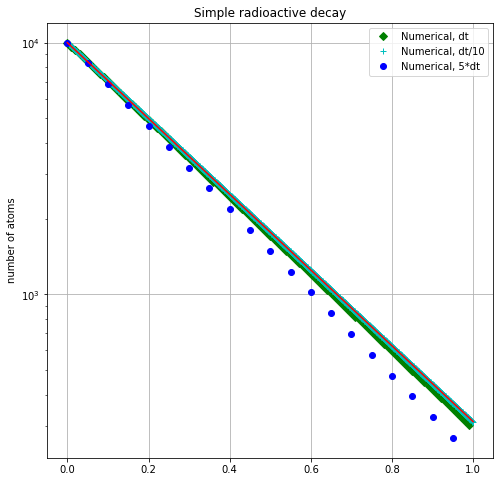

In [339]:
pylab.figure(figsize=(8,8))
numerical1 = pylab.semilogy(ts1,xs1,'gD',label='Numerical, dt')
numerical2 = pylab.semilogy(ts2,xs2, 'c+',label='Numerical, dt/10')
numerical3 = pylab.semilogy(ts3,xs3, 'bo',label='Numerical, 5*dt')

t  = numpy.arange(t0,t1,deltat/100)
analytical = pylab.semilogy(t, radioactive.analytical(natoms,t), 
                             color='r')
# Annotate the graph
pylab.title('Simple radioactive decay')
pylab.ylabel('number of atoms')
pylab.legend()
pylab.grid(True)

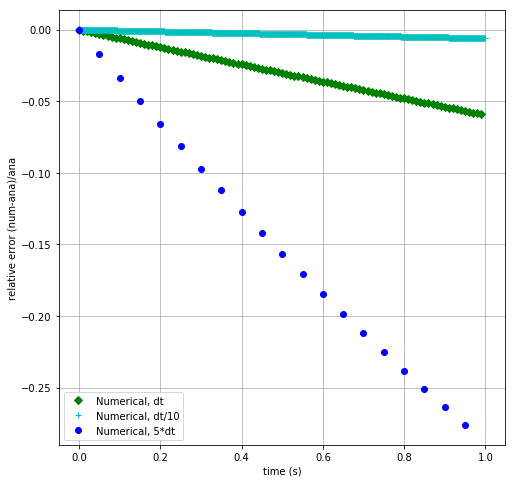

In [340]:
pylab.figure(figsize=(8,8))
pylab.ylabel('relative error (num-ana)/ana')

errors1 = radioactive.relative_error(result1,t0,t1)
ts1, xs1 = zip(*errors1)

errors2 = radioactive.relative_error(result2,t0,t1)
ts2, xs2 = zip(*errors2)

errors3 = radioactive.relative_error(result3,t0,t1)
ts3, xs3 = zip(*errors3)

error1 = pylab.plot(ts1,xs1,'gD',label='Numerical, dt' )
error2 = pylab.plot(ts2,xs2, 'c+', label='Numerical, dt/10')
error3 = pylab.plot(ts3,xs3, 'bo', label='Numerical, 5*dt')
pylab.legend()
pylab.grid(True)
pylab.xlabel('time (s)')


Generalise the `Radioactive` class to treat a problem with three types of nuclei:

- A decays to B with half-life $h_A$
- B decays to C with half-life $h_B$ 

We start with 1000000 nuclei of type A. 
There is no need to implement an analytical solution.



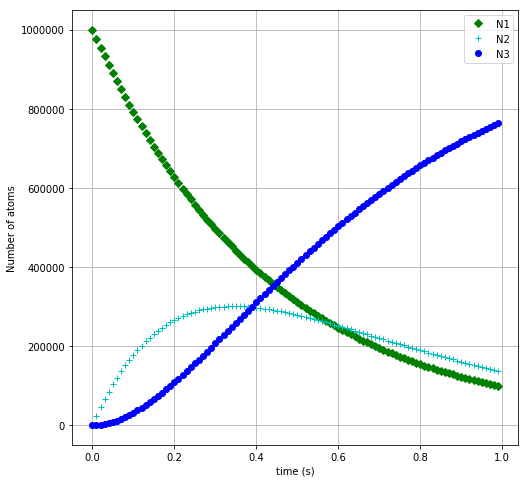

In [384]:
natoms = numpy.array([1000000, 0, 0], dtype='f') # Initial no. of atoms for each species
hlife  = numpy.array([0.3, 0.2, numpy.inf], dtype='f') # Half-life for each species (inf == stable)
t0     = 0.0   # Initial time
t1     = 1.0   # Final time of simulation
deltat = 0.01   # Size of timestep

r = Radioactive(hlife)
ds  = EulerSolver(r)

result = ds.solve(natoms,t0,t1,deltat)

pylab.figure(figsize=(8,8))
pylab.ylabel('Number of atoms')

ts,ns = zip(*result)
ns1,ns2,ns3=zip(*ns)

n1 = pylab.plot(ts,ns1,'gD',label='N1')
n2 = pylab.plot(ts,ns2, 'c+', label='N2')
n3 = pylab.plot(ts,ns3, 'bo', label='N3')
pylab.legend()
pylab.grid(True)
pylab.xlabel('time (s)')


In [380]:
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="test";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None


class myRadioButton:
    def __init__(self,name,description,options):
        self.name=name
        self.options=options
        self.description=description
    def getWidget(self):
        def on_value_change(change):
            s=shelve.open('.choices.shelve')
            key=self.getKey()
            s[key]=change['new']
            s.close()

        self.widget=widgets.RadioButtons(
            options=self.options,
            value=get_last_value(self.getKey()),
            description=self.description,
            disabled=False
        )
        self.widget.observe(on_value_change, names='value')

        return self.widget
    def getKey(self):
        return '{0}_{1}'.format(assessmentName,self.name)
        
        
def on_value_change(change):
                s=shelve.open('.choices.shelve')
                key='{0}_{1}_{2}'.format(assessmentName,self.name,i)
                s[key]=change['new']
                s.close()

def make_value_change_fn(assessmentName,name,i):
        def fn(change):
            s=shelve.open('.choices.shelve')
            key='{0}_{1}_{2}'.format(assessmentName,name,i)
            s[key]=change['new']
            s.close()
        return fn

class myCheckBoxSet:
    def __init__(self,name,description,options):
        self.name=name
        self.options=options
        self.description=description
    def getWidget(self):
        keys=['{0}_{1}_{2}'.format(assessmentName,self.name,i) for i in range(len(self.options))]    
        self.widgets=[ widgets.Checkbox(value=get_last_value(key),
    description=o,
    disabled=False
        ) for key,o in zip(keys,self.options)]
        
        txt=widgets.HTMLMath(
            value=self.description,
            placeholder='',
            description='',
        )

        
        self.widget=VBox([txt]+self.widgets)
        for i,w in enumerate(self.widgets):
            w.observe(make_value_change_fn(assessmentName,self.name,i), names='value')

        return self.widget

In [381]:
mcbs1=myCheckBoxSet('radioactiveABC1','We consider $h_A=0.3$ and $h_B=0.2$. Which of the nuclei type has the most nuclei at time $t=1$ ?',[
    'type A',
    'type B',
    'type C']
)
mcbs1.getWidget()

A Jupyter Widget

In [382]:
mcbs2=myCheckBoxSet('radioactiveABC2',
                   'We consider $h_A=0.7$ and $h_B=0.9$. Which of the nuclei type number is increasing at time $t=0.5$?',[
    'type A',
    'type B',
    'type C']
)
mcbs2.getWidget()



A Jupyter Widget